In [2]:
import mne
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import torch
import torch.nn as nn
from typing import Callable, Literal
import torch.utils
import torch.utils.data
import tqdm
import random
N_CHANNELS = 52
CHANNEL_NAMES = [f'parcel_{i}' for i in range(N_CHANNELS)]
SAMPLE_RATE = 250
TEST_SIZE = 40

In [3]:
def read_age(file_path: str):
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        participant_age = {}
        for row in reader:
            if row[0] != 'participant_id':
                participant_age[row[0]] = int(row[1])
    return participant_age
def read_single_data(file_path: str):
    raw_data = mne.io.read_raw_fif(file_path)
    data, times = raw_data[CHANNEL_NAMES]
    time = times[-1]
    return data, time
def read_data(folder_path: str, age_file_path: str, logging: bool = True):
    mne.set_log_level("WARNING")
    participant_age = read_age(age_file_path)
    total_data: list[list[np.ndarray | int]] = []
    total_time = 0
    total_count = 0
    dirs_name = os.listdir(folder_path)
    last_progress = 0
    for file_name in dirs_name:
        progress = dirs_name.index(file_name)/len(dirs_name)*100
        if (logging and progress - last_progress > 20):
            last_progress = progress
            print(f"Loading: {progress:.2f} %")
        if file_name.endswith('.fif'):
            file_path = os.path.join(folder_path, file_name)
            participant_id = file_name.split("_")[0]
            if participant_id in participant_age:
                data, data_total_time = read_single_data(file_path)
                total_time += data_total_time
                total_count += 1
                total_data.append([data, participant_age[participant_id]])
            else:
                print(f'Missing participant age: {participant_id}')
    if logging:
        print(f"Loading: {100:.2f} %")
        print("Load complete")
    mne.set_log_level("INFO")
    return total_data, total_time, total_count
def process_data(data: list[list[np.ndarray | int]], n_seconds: int, sample_rate: int) -> list[tuple[torch.Tensor, int]]:
    for i in range(len(data)):
        age = data[i][1]
        wave_data = data[i][0]
        wave_data = [wave_data[:,i*sample_rate:(i+1)*sample_rate] for i in range(n_seconds)]
        # [n_seconds, n_channels, sample_rate] -> [n_channels, n_seconds, sample_rate]
        data[i] = (torch.tensor(np.array(wave_data)).permute(1,0,2), age) 
    return data
def read_all_data(folder_path: str):
    data = []
    time = 0
    count = 0
    age_path = os.path.join(folder_path, "label.tsv")
    for i in range(1, 4):
        print(f"Loading {i}/3")
        folder_path_ = os.path.join(folder_path, f'group_{i}')
        data_, time_, count_ = read_data(folder_path_, age_path, logging=False)
        data.extend(data_)
        time += time_
        count += count_
    print("Load complete")
    return data, time, count
data, time, count = read_all_data('/kaggle/input/eeg-for-age-prediction/data')
data = process_data(data, 500, SAMPLE_RATE)

Loading 1/3
Missing participant age: sub-CC120184
Missing participant age: sub-CC120212
Missing participant age: sub-CC120137
Loading 2/3
Loading 3/3
Load complete


In [4]:
print(data[0][0].shape)

torch.Size([52, 500, 250])


In [5]:
print(time, count)
print(time/count)

90982.35999999991 160
568.6397499999995


In [6]:
random.shuffle(data)

In [10]:
def train(model: nn.Module, lossf: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], optimizer: torch.optim.Optimizer, trainloader: torch.utils.data.DataLoader, device: str):
    model.train()
    total_loss = 0
    count = 0
    for data, age in trainloader:
        optimizer.zero_grad()
        data: torch.Tensor = data.float().to(device)
        age: torch.Tensor = age.unsqueeze(1).to(device)
        predicted_age = model(data)
        loss = lossf(predicted_age, age)
        total_loss += loss.item()
        count += 1
        loss.backward()
        optimizer.step()
    return total_loss/count
def test(model: nn.Module, lossf: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], testloader: torch.utils.data.DataLoader, device: str):
    model.eval()
    total_loss = 0
    count = 0
    for data, age in testloader:
        data: torch.Tensor = data.float().to(device)
        age: torch.Tensor = age.unsqueeze(1).to(device)
        predicted_age = model(data)
        loss = lossf(predicted_age, age)
        total_loss += loss.item()
        count += 1
    return total_loss/count
def train_eval(
        model: nn.Module, 
        trainloader: torch.utils.data.DataLoader, 
        testloader: torch.utils.data.DataLoader,
        n_epochs: int,
        lr: float,
        device: str = 'cuda',
        log_step: int = 1
        ):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    lossf = nn.L1Loss() 
    train_losses = []
    test_losses = []
    for epoch in tqdm.trange(n_epochs):
        train_loss = train(model, lossf, optimizer, trainloader, device)
        test_loss = test(model, lossf, testloader, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if (epoch + 1) % log_step == 0:
            print(f'Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}')
    return train_losses, test_losses

In [8]:
class ExtractLast(nn.Module):
    def __init__(self):
        super(ExtractLast, self).__init__()
    def forward(self, rnn_output):
        return rnn_output[0][:, -1, :]
class FRNN(nn.Module):
    def __init__(self, n_channels: int, sample_rate: int, hidden_size: int, device: str):
        super(FRNN, self).__init__()
        
        self.rnns = nn.ModuleDict({ 
            str(channel): nn.Sequential(
                nn.LSTM(sample_rate, hidden_size, batch_first=True),
                ExtractLast(),
                nn.Linear(hidden_size, 1),
                nn.LeakyReLU(0.5),
                nn.Dropout(0.3)
            )
            for channel in range(n_channels) 
        })
        self.fc = nn.Linear(n_channels, 1)
        self.device = device
    def forward(self, x: torch.Tensor):
        # x :  [bsz, channels, seq, sample_rate]
        rnn_outputs = torch.empty((x.shape[0], x.shape[1]))
        for channel in range(x.shape[1]):
            result: torch.Tensor = self.rnns[str(channel)](x[:, channel])
            result = result.squeeze(1)
            rnn_outputs[:, channel] = result
        out = rnn_outputs.to(self.device)
        out = self.fc(out)
        return out

  3%|▎         | 1/30 [00:17<08:34, 17.73s/it]

Train loss: 48.3978 | Test loss: 42.1275


  7%|▋         | 2/30 [00:35<08:15, 17.68s/it]

Train loss: 22.8121 | Test loss: 19.4315


 10%|█         | 3/30 [00:52<07:54, 17.59s/it]

Train loss: 13.9228 | Test loss: 20.0722


 13%|█▎        | 4/30 [01:10<07:34, 17.49s/it]

Train loss: 9.0488 | Test loss: 20.9166


 17%|█▋        | 5/30 [01:27<07:19, 17.56s/it]

Train loss: 8.6332 | Test loss: 21.1546


 20%|██        | 6/30 [01:45<07:01, 17.55s/it]

Train loss: 7.9515 | Test loss: 19.8169


 23%|██▎       | 7/30 [02:02<06:42, 17.51s/it]

Train loss: 6.5543 | Test loss: 19.7934


 27%|██▋       | 8/30 [02:20<06:24, 17.46s/it]

Train loss: 7.0144 | Test loss: 20.3823


 30%|███       | 9/30 [02:37<06:06, 17.46s/it]

Train loss: 6.1263 | Test loss: 20.5794


 33%|███▎      | 10/30 [02:55<05:50, 17.51s/it]

Train loss: 6.5520 | Test loss: 20.1500


 37%|███▋      | 11/30 [03:12<05:33, 17.55s/it]

Train loss: 7.0768 | Test loss: 20.3978


 40%|████      | 12/30 [03:30<05:14, 17.46s/it]

Train loss: 5.9442 | Test loss: 20.3840


 43%|████▎     | 13/30 [03:47<04:57, 17.51s/it]

Train loss: 6.7222 | Test loss: 20.9827


 47%|████▋     | 14/30 [04:05<04:41, 17.61s/it]

Train loss: 6.6492 | Test loss: 20.7657


 50%|█████     | 15/30 [04:23<04:23, 17.58s/it]

Train loss: 5.7665 | Test loss: 20.6556


 53%|█████▎    | 16/30 [04:40<04:06, 17.60s/it]

Train loss: 5.3673 | Test loss: 21.1600


 57%|█████▋    | 17/30 [04:58<03:48, 17.55s/it]

Train loss: 6.1142 | Test loss: 20.6326


 60%|██████    | 18/30 [05:15<03:30, 17.58s/it]

Train loss: 5.7828 | Test loss: 20.2879


 63%|██████▎   | 19/30 [05:33<03:13, 17.56s/it]

Train loss: 5.4853 | Test loss: 20.5619


 67%|██████▋   | 20/30 [05:51<02:56, 17.64s/it]

Train loss: 6.3613 | Test loss: 20.8033


 70%|███████   | 21/30 [06:08<02:38, 17.58s/it]

Train loss: 6.0279 | Test loss: 20.4392


 73%|███████▎  | 22/30 [06:26<02:20, 17.62s/it]

Train loss: 6.2186 | Test loss: 20.5594


 77%|███████▋  | 23/30 [06:44<02:03, 17.66s/it]

Train loss: 5.5487 | Test loss: 20.5402


 80%|████████  | 24/30 [07:01<01:45, 17.56s/it]

Train loss: 5.6493 | Test loss: 20.6995


 83%|████████▎ | 25/30 [07:19<01:27, 17.57s/it]

Train loss: 6.1194 | Test loss: 20.8319


 87%|████████▋ | 26/30 [07:36<01:09, 17.46s/it]

Train loss: 5.5893 | Test loss: 20.7220


 90%|█████████ | 27/30 [07:53<00:52, 17.52s/it]

Train loss: 5.2474 | Test loss: 20.5392


 93%|█████████▎| 28/30 [08:11<00:35, 17.52s/it]

Train loss: 5.2895 | Test loss: 20.6591


 97%|█████████▋| 29/30 [08:29<00:17, 17.58s/it]

Train loss: 5.6805 | Test loss: 20.8681


100%|██████████| 30/30 [08:46<00:00, 17.56s/it]

Train loss: 5.1468 | Test loss: 20.8277


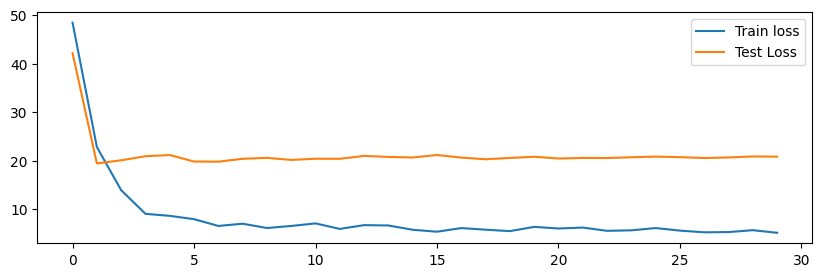

In [11]:
model = RNN(
    n_channels=N_CHANNELS,
    sample_rate=SAMPLE_RATE, 
    hidden_size=64,
    device="cuda"
)
batch_size = 1
trainloader = torch.utils.data.DataLoader(data[:-TEST_SIZE-1], batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(data[-TEST_SIZE:], batch_size=batch_size, shuffle=False, num_workers=0)
train_losses, test_losses = train_eval(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    n_epochs=30,
    lr=1e-3,
    device='cuda',
    log_step=1
)
plt.figure(figsize=(10,3))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()